In [4]:
import sys
import os
print("insert absolute path to where utils folder is located, e.g. /Users/docs/projects/datatonic-challenge")
path_to_utils = input()
sys.path.insert(0, os.path.abspath(path_to_utils + '/utils')) #point this to the where util is relatively to your working directory
from util import *

insert absolute path to where utils folder is located, e.g. /Users/docs/projects/datatonic-challenge
/Users/novikov/python_notebooks/datatonic-challenge


In [199]:
import pandas as pd
pd.set_option('display.max_columns', None) #will show all columns, comment out if not interested, as it may make the notebook slow
import numpy as np
import json 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet

In [142]:
data_dir = get_path_to_data_dir()
movie_data = pd.read_pickle(data_dir + 'pre-processed/movie_encoded_only_numeric.pkl')
movie_data = movie_data.drop(['id', 'vote_average', 'vote_count'], axis = 'columns') #dropping features which won't be available before movie release
print(type(movie_data['budget']))
#movie_data.describe()


<class 'pandas.core.series.Series'>


In [143]:


#minmax = MinMaxScaler()
#minmax_data = pd.DataFrame(minmax.fit_transform(movie_data[['budget', 'revenue', 'runtime', 'release_date']]))

def normalize_cube_root(y_cube):
    movie_data.budget**(1/3)
    y_cube = normalize(y_log)
    return y_log_norm

def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

def feature_scaling(column, df):
    cube_root = df[column]**(1/3)
    cube_norm = normalize(cube_root)
    df[column] = cube_norm
    return df

columns_to_scale = ['budget', 'revenue', 'runtime', 'release_date']
for column in columns_to_scale:
    movie_data = feature_scaling(column, movie_data)

In [144]:
movie_data.describe()

budget      revenue      runtime  release_date    lead_male  \
count  3074.000000  3074.000000  3074.000000   3074.000000  3074.000000   
mean      0.535429     0.441656     0.610748      0.739192     0.729993   
std       0.198420     0.208755     0.118027      0.211543     0.444035   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.404359     0.288359     0.522210      0.607269     0.000000   
50%       0.526473     0.427197     0.594727      0.804338     1.000000   
75%       0.678602     0.588256     0.688888      0.899122     1.000000   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

       lead_female   lead2_male  lead2_female       Action    Adventure  \
count  3074.000000  3074.000000   3074.000000  3074.000000  3074.000000   
mean      0.241054     0.559206      0.386467     0.259597     0.169811   
std       0.427793     0.496563      0.487019     0.438485     0.375528   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.000000     0.000000      0.000000     0.000000     0.000000   
50%       0.000000     1.000000      0.000000     0.000000     0.000000   
75%       0.000000     1.000000      1.000000     1.000000     0.000000   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

         Animation       Comedy        Crime  Documentary        Drama  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.048796     0.365647     0.165908     0.014964     0.462264   
std       0.215477     0.481690     0.372058     0.121429     0.498655   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     1.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            Family      Fantasy      Foreign      History       Horror  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.103774     0.091412     0.001952     0.040013     0.109629   
std       0.305016     0.288241     0.044144     0.196022     0.312478   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Music      Mystery      Romance  Science Fiction  TV Movie  \
count  3074.000000  3074.000000  3074.000000      3074.000000    3074.0   
mean      0.039037     0.082303     0.189980         0.116461       0.0   
std       0.193715     0.274871     0.392349         0.320829       0.0   
min       0.000000     0.000000     0.000000         0.000000       0.0   
25%       0.000000     0.000000     0.000000         0.000000       0.0   
50%       0.000000     0.000000     0.000000         0.000000       0.0   
75%       0.000000     0.000000     0.000000         0.000000       0.0   
max       1.000000     1.000000     1.000000         1.000000       0.0   

          Thriller          War      Western        1960s        1970s  \
count  3074.000000  3074.000000  3074.000000  3074.000000  3074.000000   
mean      0.292453     0.033182     0.017241     0.004880     0.008783   
std       0.454963     0.179139     0.130191     0.069695     0.093322   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000 

In [151]:
Y = (movie_data['revenue'])
X = movie_data.drop(['revenue'], axis = 'columns')
print(X.shape)
var = VarianceThreshold(threshold=0.995 * (1 - 0.995))
#X = var.fit_transform(X)
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

(3074, 2159)
(3074, 2159)


In [84]:
clf = SVR(kernel = 'linear', C=0.01, epsilon=0.002)
clf.fit(X_train, Y_train)
pred_clf = clf.predict(X_test)
coefs_clf = clf.coef_
print('R^2 for SVR with linear kernel:', clf.score(X_test, Y_test), r2_score(Y_test, pred_clf))

KeyboardInterrupt: 

In [219]:
ridge = Ridge(alpha = 15)
selector = RFE(ridge, 500, step = 100)
X_train_fs = selector.fit_transform(X_train, Y_train)
X_test_fs = selector.transform(X_test)
print(X_train_fs.shape)
ridge.fit(X_train_fs, Y_train)
pred_ridge1 = ridge.predict(X_test_fs)
pred_ridge = selector.predict(X_test)
#coefs_ridge = ridge.coef_
print('R^2 for ridge regression:',  r2_score(Y_test, pred_ridge), r2_score(Y_test, pred_ridge1))

(2459, 500)
R^2 for ridge regression: 0.5262651659518451 0.5262651659518451


In [155]:
ridge.fit(X_train, Y_train)
ridge_coefs = list(ridge.coef_)

In [156]:
print(len(list(selector.ranking_)), len(list(ridge.coef_)))

2159 2159


In [187]:
feat_coef = list(ridge.coef_)
index = X.columns
feat_imp = pd.DataFrame({'rank': list(selector.ranking_),
                         'coef': ridge_coefs}, index = index)

best_feat = feat_imp.loc[feat_imp['rank'] == 1]
best_feat = best_feat.sort_values(by=['coef'], ascending=False)
worst_feat = best_feat.sort_values(by=['coef'])
top10 = best_feat.iloc[:10, :]
bottom10 = worst_feat.iloc[:10, :]

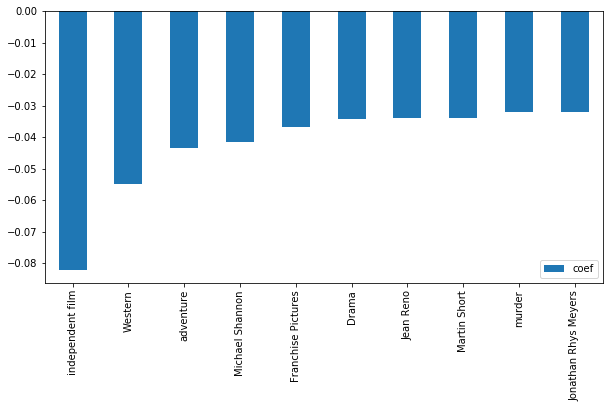

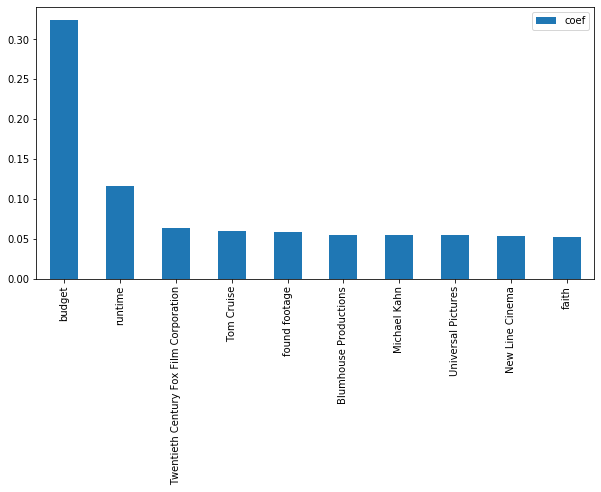

In [197]:
bottom10_plot = bottom10.plot.bar(y = 'coef', figsize=(10,5))
top10_plot = top10.plot.bar(y = 'coef', figsize = (10,5))
bototm10_fig = bottom10_plot.get_figure()
top10_fig = top10_plot.get_figure()
bototm10_fig.savefig(path_to_utils+'/plots/bottom10_features.png', bbox_inches='tight')
top10_fig.savefig(path_to_utils+'/plots/top10_features.png', bbox_inches='tight')

In [214]:
elastic = ElasticNet(alpha = 0.001, l1_ratio = 0.2)
selector_elastic = RFE(elastic, 500, step = 100)
X_train_fs = selector_elastic.fit_transform(X_train, Y_train)
X_test_fs = selector_elastic.transform(X_test)
print(X_train_fs.shape)
elastic.fit(X_train_fs, Y_train)
pred_elastic1 = elastic.predict(X_test_fs)
pred_elastic = selector_elastic.predict(X_test)
#coefs_ridge = ridge.coef_
print('R^2 for elastic net:',  r2_score(Y_test, pred_elastic), r2_score(Y_test, pred_elastic1))

(2459, 500)
R^2 for elastic net: 0.532837632532053 0.532837632532053


In [222]:
elastic.fit(X_train, Y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [223]:
elastic_coefs = list(elastic.coef_)
index = X.columns
feat_imp = pd.DataFrame({'rank': list(selector_elastic.ranking_),
                         'coef': elastic_coefs}, index = index)

best_feat = feat_imp.loc[feat_imp['rank'] == 1]
best_feat = best_feat.sort_values(by=['coef'], ascending=False)
worst_feat = best_feat.sort_values(by=['coef'])
top10 = best_feat.iloc[:10, :]
bottom10 = worst_feat.iloc[:10, :]

In [224]:
rand_for = RandomForestRegressor(n_estimators = 100)
rand_for.fit(X_train, Y_train)
pred_rand_for = rand_for.predict(X_test)
#coefs_ridge = rand_for.coef_
print('R^2 for random forest regressor:', r2_score(Y_test, pred_rand_for))

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
extra_tr = ExtraTreesRegressor(min_samples_split = 100)
extra_tr.fit(X_train, Y_train)
pred_extra_tr = extra_tr.predict(X_test)
print('R^2 for extra trees regressor:', r2_score(Y_test, pred_extra_tr))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(max_features = 'auto', min_samples_split=1000, min_samples_leaf= 10)
dec_tree.fit(X_train, Y_train)
pred_dec_tree = dec_tree.predict(X_test)
print('R^2 for extra trees regressor:', r2_score(Y_test, pred_dec_tree))

In [12]:
from xgboost import XGBRegressor
xgb = XGBRegressor(colsample_bytree= 0.6, gamma= 1, max_depth= 4, min_child_weight= 10,
                         subsample = 0.8, objective='reg:squarederror')
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
print('R^2 for random forest regressor:', r2_score(Y_test, pred_xgb))

R^2 for random forest regressor: 0.39706948216034277


In [93]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor((700, 700), alpha = 0.2, verbose = True)
nn.fit(X_train, Y_train)
pred_nn = nn.predict(X_test)
#coefs_ridge = rand_for.coef_
print('R^2 for neural net:', r2_score(Y_test, pred_nn)) #0.3816737188287369

Iteration 1, loss = 0.83896704
Iteration 2, loss = 0.53970457
Iteration 3, loss = 0.35233558
Iteration 4, loss = 0.23663877
Iteration 5, loss = 0.16749443
Iteration 6, loss = 0.12507299
Iteration 7, loss = 0.09715734
Iteration 8, loss = 0.07800677
Iteration 9, loss = 0.06387442
Iteration 10, loss = 0.05336367
Iteration 11, loss = 0.04532296
Iteration 12, loss = 0.03945819
Iteration 13, loss = 0.03480764
Iteration 14, loss = 0.03063154
Iteration 15, loss = 0.02666472
Iteration 16, loss = 0.02342926
Iteration 17, loss = 0.02076102
Iteration 18, loss = 0.01858735
Iteration 19, loss = 0.01702196
Iteration 20, loss = 0.01575109
Iteration 21, loss = 0.01457976
Iteration 22, loss = 0.01366922
Iteration 23, loss = 0.01308116
Iteration 24, loss = 0.01213160
Iteration 25, loss = 0.01086944
Iteration 26, loss = 0.01009107
Iteration 27, loss = 0.00933319
Iteration 28, loss = 0.00881777
Iteration 29, loss = 0.00868224
Iteration 30, loss = 0.00844092
Iteration 31, loss = 0.00820231
Iteration 32, los